# CS480/680, Spring 2023, Assignment 3
## Designer: Chengjie Huang; Instructor: Hongyang Zhang
Released: June 26; Due: July 16, noon

Notes:
* Please save a copy of this notebook to avoid losing your changes.
* Debug your code and ensure that it can run.
* Save the output of each cell. Failure to do so may result in your coding questions not being graded.
* To accelerate the training time, you can use Google Colab and choose 'Runtime' -> 'Change runtime type' -> 'Hardware accelerator' and set 'Hardware accelerator' to 'GPU'. This assignment may be more time-consuming, so you may need to plan ahead and leave enough time for model training.

In [1]:
# In addition to numpy, pytorch, and other standard libraries, you will need the following for this assignment
!pip install transformers datasets

## Question 1: Large Language Model (40 pts)
Large pre-trained language models such as GPT can be useful for many natural language tasks other than text generation. In this question, we will take a look at one of such tasks: question-answering (QA).

In QA task, the model is given some **context** text and a **question** related to the context. The model is tasked to generate the correct answer based on the context and question. For example, a context could be "Joe enjoys pizza but prefers pasta over anything else", and given a question "What's Joe's favorite food", the model should output "pasta".

In this question, we will extend and fine-tune a pre-trained large language model (GPT2) to perform question-answering task.

### 1.1 SQuAD Dataset (5 pts)

A popular dataset for question-answering task is the Stanford Question-answering Dataset (SQuAD) ([Rajpurkar, Pranav, et al. "Squad: 100,000+ questions for machine comprehension of text." arXiv preprint arXiv:1606.05250 (2016).](https://arxiv.org/abs/1606.05250)). The code below will automatically download and load the dataset. The training and validation split can be accessed with `squad_dataset['train']` and `squad_dataset['validation']` respectively.

First familiarize yourself with the format of the SQuAD dataset.<br>
In the following cells, print the size of each split as well as one example from each split in the following format:
```
Train/validation split: 10000 samples
Sample id: 56de57394396321400ea2830
Context: Joe enjoys pizza but prefers pasta over anything else
Question: What's Joe's favorite food
Answer: pasta
```

In [2]:
from datasets import load_dataset
squad_dataset = load_dataset("squad")

/home/alex/miniconda3/envs/exp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset squad (/home/alex/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)
100%|██████████| 2/2 [00:00<00:00, 755.32it/s]


In [3]:
####################################################################################
# IMPLEMENT ME!
train_split, val_split = squad_dataset["train"], squad_dataset["validation"]
print(f"Size of train split: {len(train_split)}")
print(f"Sample id: {train_split[0]['id']}")
print(f"Context: {train_split[0]['context']}")
print(f"Question: {train_split[0]['question']}")
print(f"Answer: {train_split[0]['answers']['text'][0]}")
print("--------------")
print(f"Size of train split: {len(val_split)}")
print(f"Sample id: {val_split[0]['id']}")
print(f"Context: {val_split[0]['context']}")
print(f"Question: {val_split[0]['question']}")
print(f"Answer: {val_split[0]['answers']['text'][0]}")
####################################################################################

Size of train split: 87599
Sample id: 5733be284776f41900661182
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer: Saint Bernadette Soubirous
--------------
Size of train split: 10570
Sample id: 56be4db0acb8001400a502ec
Context: Super Bowl 50 was an America

### 1.2 Extending GPT2 for question-answering task (25 pts)
In this part, we will extend the GPT2 model to produce answers from the context based on the questions. To make use of the pre-trained GPT2 model, we will treat it as a feature extractor to compute token-wise feature vectors and add additional MLP layers to process the features for the QA task. These additional task-specific layers are sometimes called **"adapters"**.

Use the skeleton code below and implement the following three core components:
1. **[5 pts] Add additional MLP layer(s) to predict the location of the answer within the input.** <br>You can formulate this problem however you see fit. Below are two possible options:
    * Classify the start and end locations of the answer. For example, given a input text of length 5 after tokenization, suppose the answer starts at token `2` and ends at token `4`, the model should predict `[0 0 1 0 0]` and `[0 0 0 0 1]` as the start and end location respectively.
    * Directly regress the start and end locations, or the start location + length of the answer.<br><br>
2. **[10 pts] Use the additional layer(s) to compute the location of the answer**
3. **[10 pts] Implement task-specific loss for question-answering** <br>Depending on the approach you choose to implement (classification vs. regression), you need to use the appropriate loss.

Unlike image data, text input can have varying length, which makes batch training and loss computation more challenging.
For simplicity, you can assume the batch size is 1 in this question. I.e., the `question`, `context` and `answer` belong to a single sample in the dataset.

In [4]:
import torch
import torch.nn as nn
from transformers import GPT2TokenizerFast, GPT2Model

class GPT2QuestionAnswering(nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        
        ####################################################################################
        # IMPLEMENT ME!
        # Add additional layers for predicting the location of the answer
        self.start_classifier = nn.Sequential(
            nn.Linear(self.gpt2.config.n_embd, 100),
            nn.LeakyReLU(0.1),
            nn.Linear(100, 1),
        )

        self.end_classifier = nn.Sequential(
            nn.Linear(self.gpt2.config.n_embd, 100),
            nn.LeakyReLU(0.1),
            nn.Linear(100, 1),
        )
        # self.output_layer_start1 = nn.Linear(self.gpt2.config.n_embd, self.gpt2.config.n_embd * 2)
        # self.output_layer_start2 = nn.Linear(self.gpt2.config.n_embd *2, self.gpt2.config.n_positions)
        # self.output_layer_end1 = nn.Linear(self.gpt2.config.n_embd, self.gpt2.config.n_embd * 2)
        # self.output_layer_end2 = nn.Linear(self.gpt2.config.n_embd *2, self.gpt2.config.n_positions)
        # self.layer_norm1 = nn.LayerNorm(self.gpt2.config.n_positions)
        # self.layer_norm2 = nn.LayerNorm(self.gpt2.config.n_positions)
        # self.relu = nn.LeakyReLU(0.1)
        #self.softmax = nn.Softmax()
        ####################################################################################

    def forward(self, question, context, answer=None):
        question = question.strip()
        context = context.strip()

        inputs = self.tokenizer(question, context, return_tensors='pt', return_offsets_mapping=True)
        input_ids = inputs.input_ids[:,:self.gpt2.config.n_positions]
        attention_mask = inputs.attention_mask[:,:self.gpt2.config.n_positions]
        if torch.cuda.is_available:
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
        features = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']

        ####################################################################################
        # IMPLEMENT ME!
        # Using the additional layers to compute location of the answer based on the hidden state features
        # logits_start = features[:, -1, :]
        # logits_start = self.output_layer_start1(logits_start)
        # logits_start = self.relu(logits_start)
        # logits_start = self.output_layer_start2(logits_start)
        # #logits_start = self.layer_norm1(logits_start)
        # #logits_start = self.softmax(logits_start)

        # logits_end = features[:, -1, :]
        # logits_end = self.output_layer_end1(logits_end)
        # logits_end = self.relu(logits_end)
        # logits_end = self.output_layer_end2(logits_end)
        # #logits_end = self.layer_norm1(logits_end)
        # #logits_end = self.softmax(logits_end)
        logits_start = self.start_classifier(features)
        logits_end = self.end_classifier(features)
        ####################################################################################

        if self.training:
            ####################################################################################
            # IMPLEMENT ME!
            # In training mode, we want to return the loss based on the ground truth answer
            # You may change the 
            
            return self.loss(logits_start, logits_end, 
                             inputs.sequence_ids()[: self.gpt2.config.n_positions], 
                             inputs.offset_mapping[: self.gpt2.config.n_positions],
                             answer)
            ####################################################################################
        else:
            ####################################################################################
            # IMPLEMENT ME!
            # In inference mode, we want to return the answer string based on the predicted start and end indices
            answer_start_index = torch.argmax(logits_start.squeeze(-1)).item()
            answer_end_index = torch.argmax(logits_end.squeeze(-1)).item()
            ####################################################################################
            return self.tokenizer.decode(inputs.input_ids[0, answer_start_index : answer_end_index + 1]).strip()

    
    ####################################################################################
    # IMPLEMENT ME!
    def loss(self, logits_start, logits_end, sequence_ids, offset_mapping, answer):
        # Compute the loss based on the answers
        # Tip1: If you choose the classification approach, then you need the start and end locations
        #       of the answer within the **tokenized** input as your classification target.
        #       You may need to use inputs.offset_mapping from the input tokenization.
        #       See https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizerFast.__call__.return_offsets_mapping
        # Tip2: If you choose the regression approach, then you can use answer['answer_start']
        #       and length of the answer as your regression target.

        # x = torch.zeros((1, self.gpt2.config.n_positions)).cuda()
        # start_idx = answer["answer_start"][0]
        # end_idx = answer["answer_start"][0] + len(answer["text"][0])
        # for i in range(min(input_ids.offset_mapping.shape[1], self.gpt2.config.n_positions)):
        #     start = input_ids.offset_mapping[0, i, 0]
        #     end = input_ids.offset_mapping[0, i, 1]
        #     if start < start_idx and start_idx <= end:
        #         x[0, i] = 1
        #         break
        # y = torch.zeros((1, self.gpt2.config.n_positions)).cuda()
        # for i in range(min(input_ids.offset_mapping.shape[1], self.gpt2.config.n_positions)):
        #     start = input_ids.offset_mapping[0, i, 0]
        #     end = input_ids.offset_mapping[0, i, 1]
        #     if start < end_idx and end_idx <= end:
        #         y[0, i] = 1
        
        # loss = nn.CrossEntropyLoss()
        # return loss(logits_start, x) + loss(logits_end, y)
        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])

        offsets = offset_mapping[0]
        start_position = sequence_ids.index(1) - 1
        for i in range(sequence_ids.index(1), len(sequence_ids)):
            if offsets[i][0] <= start_char and start_char < offsets[i][1]:
                start_position = i
                break
        
        end_position = len(sequence_ids)-1
        for j in range(sequence_ids.index(1), len(sequence_ids)):
            if offsets[j][0] <= end_char and end_char <= offsets[j][1]:
                end_position = j
                break
                
        x = torch.zeros((1, len(sequence_ids), 1)).cuda()
        y = torch.zeros((1, len(sequence_ids), 1)).cuda()
        x[0, start_position, 0] = 1
        y[0, end_position, 0] = 1

        loss = nn.CrossEntropyLoss()
        return (loss(logits_start, x) + loss(logits_end, y)) / 2
    ####################################################################################

We can evaluate the pre-trained model's performance on the validation split. Since the model has not been adapted to the question-answering task yet, and additional untrained layers have been added, we expect the model to perform poorly.

In question-answering task, we use two evaluation metrics:
* **Exact match**: the percentage of predictions that match the ground truth answer exactly
* **F1 score**: the average overlap (in terms of tokens) between the prediction and ground truth answer

Higher values are better for both metrics. For reference, humans can achieve 77.0% exact match and 86.8% F1 score, while SOTA method achieves 90% exact match and over 95% F1 score.

In [5]:
def evaluate(model, dataset, metric):
    from tqdm.autonotebook import tqdm
    model = model.eval()
    preds = []
    for idx, data in enumerate(tqdm(dataset['validation'])):
        preds.append(dict(id=data['id'], prediction_text=model(data['question'], data['context'], data['answers'])))
    references = [dict(answers=data['answers'], id=data['id']) for data in dataset['validation']]
    return metric.compute(predictions=preds, references=references)

In [6]:
from datasets import load_metric

squad_metric = load_metric('squad')
model = GPT2QuestionAnswering()
if torch.cuda.is_available:
    model = model.cuda()

evaluate(model, squad_dataset, squad_metric)

/tmp/ipykernel_13030/1889257040.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric('squad')
100%|██████████| 10570/10570 [01:33<00:00, 113.55it/s]


{'exact_match': 0.01892147587511826, 'f1': 4.037343538673702}

### 1.3 Fine-tuning GPT2 on Squad (10 pts)
To adapt a pre-trained model to a specific downstream task (in this case the question-answering task), a common technique is to **"fine-tune"** the model. Fine-tuning simply means training the model using task-specific data, typically with shorter epochs and smaller learning rates. Certain part of the model (e.g., pre-trained layers or early layers) can also be frozen, meaning the weights are not updated during training.

In this part, we will fine-tune the model on SQuAD dataset.<br>
In the cell below, implement the training loop and record the loss values in a list to be plotted later.

**Note:** due to the size of the model and dataset, it is not required to train for too many iterations since this question will not be graded purely based on the performance of your model.

##### Optional Objectives
* **Freezing GPT2 Layers:** Depending on the additional layers you added to the network in the previous part, you may choose to freeze the pre-trained GPT2 layers during fine-tuning. In PyTorch, this can be achieved by setting `requires_grad=False` for the layers of interest. You are encouraged to try both and note your observations.
* **Gradient Accumulation:** The model from previous question is not suitable for batch training, which could increase the stochasiticy of the training process and make convergence slower. One way to circumvent this problem is via gradient accumulation, wherein the gradient is accumulated for multiple iterations before the weights are updated, which increases the effective batch size. In PyTorch, this can be implemented by accumulating the loss and performing `zero_grad()` and `step()` every few iterations instead of every iteration.

In [7]:
from tqdm.autonotebook import tqdm
losses = []

####################################################################################
# IMPLEMENT ME!
num_epochs = 3

accum_steps = 5
####################################################################################

model = model.train()
optimizer = torch.optim.Adam(model.parameters())
for e in range(num_epochs):
    # Shuffle dataset in each epoch
    indices = torch.randperm(len(squad_dataset["train"])).tolist()

    # tqdm gives you a nice little progress bar
    pbar = tqdm(indices)
    for i, idx in enumerate(pbar):
        # Obtain data from training split
        data = squad_dataset['train'][idx]

        ####################################################################################
        # IMPLEMENT ME!
        loss = model(question=data["question"], context=data["context"], answer=data["answers"]) / accum_steps
        loss.backward()
        if i % accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        ####################################################################################

        # Record loss values
        losses.append(loss.item())
        pbar.set_postfix(loss=loss.item())

100%|██████████| 87599/87599 [51:08<00:00, 28.55it/s, loss=0.727]   


Plot the loss values over the iterations.

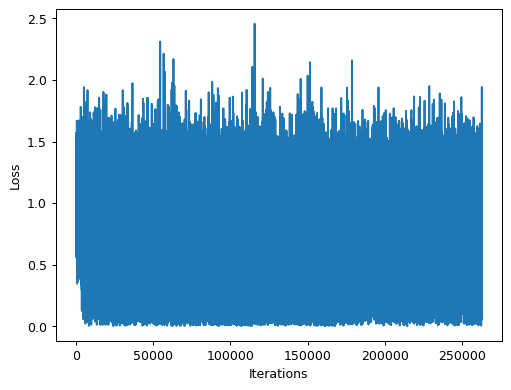

In [8]:
import matplotlib.pyplot as plt
plt.figure(dpi=90)
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

Evaluate the model performance after fine-tuning. You should see a much higher score compared to the previous results.

**Note:** this question will not be graded based on the performance of your model. However, together with the code and the loss plot in the previous parts, the performance will be used to judge if the fine-tuning is implemented properly.

In [9]:
evaluate(model, squad_dataset, squad_metric)

100%|██████████| 10570/10570 [01:34<00:00, 112.35it/s]


{'exact_match': 6.603595080416272, 'f1': 12.718892982016246}

Try the model using your own text and question. Can it give you the correct answer?

In [18]:
model('How many world cups has Pele won?', 'Pele has won 3 world cups.', {"text": ["3"], "answer_start": [13]})

'15, 1999'

In [11]:
model.tokenizer('How many world cups has Pele won?', 'Pele has won 3 world cups.', return_tensors='pt', return_offsets_mapping=True)

{'input_ids': tensor([[ 2437,   867,   995, 14180,   468,  2631,   293,  1839,    30,  6435,
           293,   468,  1839,   513,   995, 14180,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'offset_mapping': tensor([[[ 0,  3],
         [ 3,  8],
         [ 8, 14],
         [14, 19],
         [19, 23],
         [23, 26],
         [26, 28],
         [28, 32],
         [32, 33],
         [ 0,  2],
         [ 2,  4],
         [ 4,  8],
         [ 8, 12],
         [12, 14],
         [14, 20],
         [20, 25],
         [25, 26]]])}

In [12]:
model.tokenizer.decode(torch.tensor([513]))
'Pele has won 3 world cups.'.index("3")

13

## Question 2: GAN (60 pts)
In this question, you will be designing and training a GAN for image generation.

Training a GAN for image generation can be computationally demanding. Luckily, MNIST dataset provides 28x28 images of handwritten digits, allowing a GAN to be trained more quickly. Below are some examples from the digits dataset:

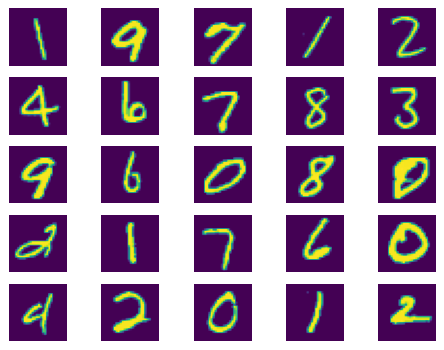

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

mnist = MNIST(root='.', download=True)
images = np.stack([data[0] for data in mnist]).astype(np.float32)
images = images / 128 - 1    # normalize between -1 and 1
plt.figure(dpi=90)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[np.random.choice(len(images))])
    plt.axis('off')
plt.show()

**Note:** You are allowed to use other **publicly available** image datasets for this question. If you choose to do so, please include the link to the dataset you use, and replace the cell above to visualize examples from your dataset.

### 2.1 Generator and Discriminator (20 pts)
In this part, you need to implement a generator and discriminator model using the skeleton code below. Recall that
* The **generator** takes a randomly sampled noise $z$ as input and outputs an image with the same size as the dataset
* The **discriminator** takes an image as input and performs a binary classification

In this case, both the generator and discriminator should be convolutional neural networks (CNNs). You may not use a pretrained network, but other design decisions such as the depth and width of the network are up to you.

Depending on the resources available to you, you may choose to implement a small network.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        ####################################################################################
        # IMPLEMENT ME!
        raise NotImplementedError
        ####################################################################################

    def forward(self, x):
        ####################################################################################
        # IMPLEMENT ME!
        raise NotImplementedError
        ####################################################################################

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        ####################################################################################
        # IMPLEMENT ME!
        raise NotImplementedError
        ####################################################################################

    def forward(self, x):
        ####################################################################################
        # IMPLEMENT ME!
        raise NotImplementedError
        ####################################################################################

gen = Generator()
disc = Discriminator()
if torch.cuda.is_available:
    gen = gen.cuda()
    disc = disc.cuda()

NotImplementedError: 

### 2.2 Generate image samples from generator (10 pts)

During the training and inference, the generator needs to generate batch of images from random noise.
Implement the generation function below.

**Note:** This function will later be used in training, therefore you need to be careful and avoid cutting off the gradient accidentally

In [ ]:
def generate_samples(model, num_samples):
    ####################################################################################
    # IMPLEMENT ME!
    # The shape of the returned samples should be [num_samples, H, W]
    raise NotImplementedError
    ####################################################################################

Without any training, the samples generated by the generator does not resemble any digit in the dataset.

In [ ]:
gen.eval()
samples = generate_samples(gen, 25).detach().cpu().numpy()
plt.figure(dpi=90)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(samples[i])
    plt.axis('off')
plt.show()

### 2.3 GAN training algorithm (25 pts)
In this part, you will implement the GAN training algorithm, which involves alternating the training of discriminator and generator.

**Note:** You may start with the standard GAN loss ([Goodfellow, Ian, et al. "Generative adversarial networks." Communications of the ACM 63.11 (2020): 139-144.](https://arxiv.org/abs/1406.2661)). If you have extra time and resources, you can explore other GAN formulations that either improves convergence or alleviates the mode-collapse problem. For instance, LSGAN ([Mao, Xudong, et al. "Least squares generative adversarial networks." Proceedings of the IEEE international conference on computer vision. 2017.](https://arxiv.org/abs/1611.04076)) and Wasserstein GAN ([Arjovsky, Martin, Soumith Chintala, and Léon Bottou. "Wasserstein generative adversarial networks." International conference on machine learning. PMLR, 2017.](http://proceedings.mlr.press/v70/arjovsky17a/arjovsky17a.pdf)) are both great options.

In [ ]:
def train_gan(gen, disc, images, num_epochs, batch_size):
    from tqdm.autonotebook import tqdm
    from torch.utils.data import DataLoader

    losses_gen = []
    losses_disc = []

    gen.train()
    disc.train()
    loader = DataLoader(images, batch_size=batch_size, shuffle=True)

    ####################################################################################
    # IMPLEMENT ME!

    # 1. [5 pts] Build optimizer for each model and choose an appropriate learning rate
    #    You may specify different optimizers or learning rates for generator and discrminator
    #    to balance the training loss and avoid one model overpowering the other.
    #    Ideally we would like to reach an equilibrium between the generator and discriminator.
    optimizer_gen = ...
    optimizer_disc = ...

    pbar = tqdm(range(num_epochs))
    for e in pbar:
        for i, data_real in enumerate(loader):
            if torch.cuda.is_available:
                data_real = data_real.cuda()

            # 2. Update discriminator
            # 2.1. Unfreeze discriminator
            disc.train()
            disc.requires_grad_(True)

            # 2.2. [5 pts] Construct inputs and training labels for discriminator
            #      The discriminator training should use both real and fake samples
            #      Tip: since we do not want to update the generator, the fake samples
            #           need to be detached from the computation graph. You can use
            #           detach().clone() for this operation.
            inputs_disc = ...
            labels_disc = ...
            if torch.cuda.is_available:
                inputs_disc = inputs_disc.cuda()
                labels_disc = labels_disc.cuda()

            # 2.4. [5 pts] Discrminator training 
            #      This should include loss computation and weight updates
            #      You can choose implement standard GAN, LSGAN, or Wasserstein gan loss
            loss_disc = ...
            losses_disc.append(loss_disc.item())

            # 3. Update generator
            # 3.1. Freeze discriminator
            disc.eval()
            disc.requires_grad_(False)

            # 3.2. [5 pts] Construct input and training labels for the generator
            #      The generator training only uses fake samples, since in this step
            #      only the generator will be updated.
            #      The training labels should be different from the discriminator
            #      labels since we want to optimize the generator in the opposite
            #      gradient direction in order to "fool" the discriminator.
            inputs_gen = ...
            labels_gen = ...
            if torch.cuda.is_available:
                inputs_gen = inputs_gen.cuda()
                labels_gen = labels_gen.cuda()

            # 3.4. [5 pts] Generator training
            #      This should include loss computation and weight updates
            #      You can choose implement standard GAN, LSGAN, or Wasserstein gan loss
            loss_gen = ...
            losses_gen.append(loss_gen.item())
    ####################################################################################

            pbar.set_postfix(loss_gen=losses_gen[-1], loss_disc=losses_disc[-1])
    return losses_gen, losses_disc

You may change the number of epochs and batch size based on the time and resources available to you.

In [ ]:
num_epochs = ...
batch_size = ...
losses_gen, losses_disc = train_gan(gen, disc, images, num_epochs=num_epochs, batch_size=batch_size)

### 2.4 Observations and Analysis (5 pts)

**[2.5 pts]** Use the code below to plot the losses for the generator and discriminator. Do you see any problem with the training process?<br> Do you think your GAN has converged? Why and why not?

**Answer:**

In [ ]:
plt.figure(dpi=90)
plt.plot(losses_disc, label='Dicriminator')
plt.plot(losses_gen, label='Generator')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

**[2.5 pts]** Use the code below to visualize some images generated by your GAN. Do you see any problem with the samples generated by your GAN?<br> Do you think your GAN has mode collapse problem? Why and why not?

**Answer:**

In [ ]:
gen.eval()
samples = generate_samples(gen, 25).detach().cpu().numpy()
plt.figure(dpi=90)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(samples[i])
    plt.axis('off')
plt.show()